In [88]:
%matplotlib inline
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [89]:
import os

import cv2
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from scipy import ndimage
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [90]:
model = None
torch.manual_seed(42)
sns.set_theme("notebook", "darkgrid")
np.random.seed(42)
torch.cuda.is_available()

True

In [91]:
root_path = os.path.join(os.path.abspath('..'), "data", "chest_xray")
folders = ('test', 'train', 'val')
img_types = ('NORMAL', 'PNEUMONIA')


def generate_images_list(img_type, sample_size=10):
    images = list()
    for folder in folders:
        path = os.path.join(root_path, folder, img_type)
        images += [os.path.join(path, f) for f in os.listdir(path)]
    images = tuple(images)
    return np.random.choice(images, sample_size, replace=False)

In [92]:
img_sample = 10
images = np.zeros((img_sample, len(img_types)), dtype="U256")
for column, img_type in enumerate(img_types):
    img_list = generate_images_list(img_type, img_sample)
    for row, img in enumerate(img_list):
        images[row, column] = img

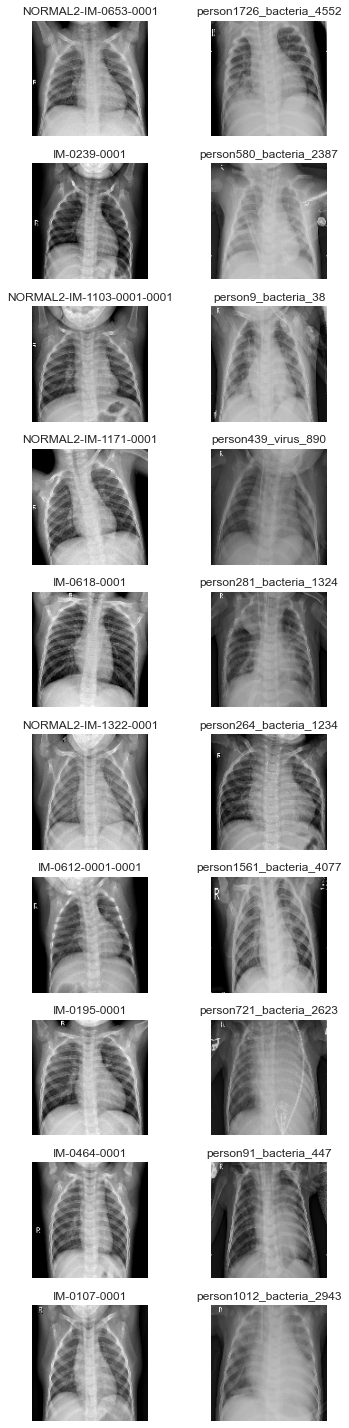

In [93]:
fig: plt.Figure = plt.figure(figsize=(img_sample * 10 / 2, 2 * 10), dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i * 2 + j + 1
        img = images[i, j]
        ax: plt.Axes = fig.add_subplot(img_sample, 2, plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        img_ar = cv2.resize(img_ar, (128, 128))
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-170)
plt.show()

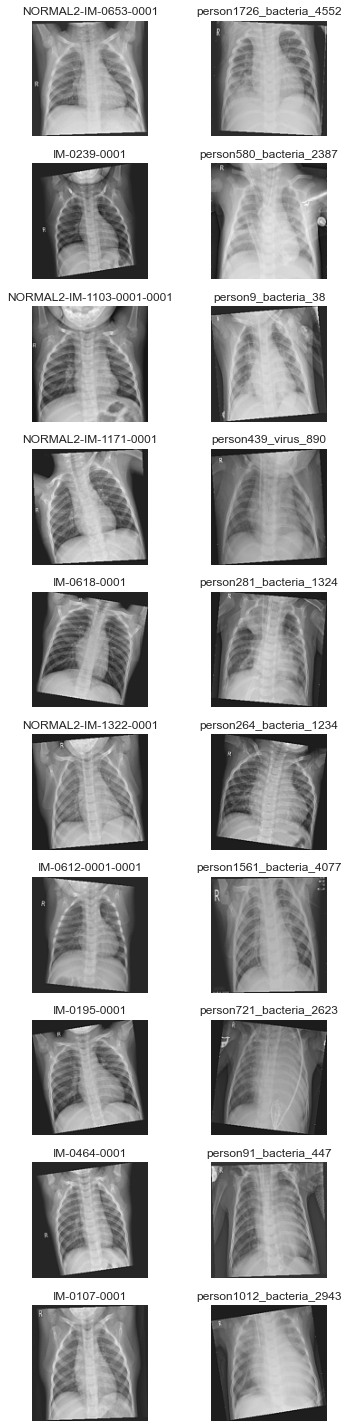

In [94]:
fig: plt.Figure = plt.figure(figsize=(img_sample * 10 / 2, 2 * 10), dpi=72)
for i in range(img_sample):
    for j in range(len(img_types)):
        plot_pos = i * 2 + j + 1
        img = images[i, j]
        ax: plt.Axes = fig.add_subplot(img_sample, 2, plot_pos)
        ax.axis("off")
        img_ar = cv2.imread(img)
        cv2.cvtColor(img_ar, cv2.COLOR_BGR2GRAY)
        img_ar = cv2.resize(img_ar, (128 * 2, 128 * 2))
        img_ar = ndimage.rotate(img_ar, np.random.randint(-10, 10))
        img_ar = cv2.GaussianBlur(img_ar, (5, 5), 1, 1)
        if np.random.random() < 1/10000:
            img_ar = cv2.flip(img_ar, 1)

        img_ar = img_ar - (cv2.GaussianBlur(img_ar, (9, 9), 1, 1)*0.7)
        img_ar -= img_ar.min()
        img_ar /= img_ar.max()
        img_ar = cv2.resize(img_ar, (128, 128))
        # img_ar = img_ar - cv2.bilateralFilter(img_ar,3,90,90)

        # img_ar = cv2.GaussianBlur(img_ar,(21,21),10)
        ax.imshow(img_ar, cmap="gray")
        ax.set_title(img.split(".")[0].split("\\")[-1].split("/")[-1])
plt.tight_layout(w_pad=-170)
plt.show()


In [95]:
class PneumoniaModel(nn.Module):
    def __init__(self, input_shape, dropout=0.1, n_filters=16):
        super(PneumoniaModel, self).__init__()
        self.conv1 = nn.Conv2d(1, n_filters, 3, 1)
        self.pool1 = nn.MaxPool2d((3, 3), stride=1)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(n_filters, n_filters//2, (3, 3), 1)
        self.pool2 = nn.MaxPool2d((3, 3), stride=1)
        self.dropout2 = nn.Dropout(dropout)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(n_filters//2 * (input_shape[0] - 8) * (input_shape[1] - 8), 32 * 32)
        self.activation1 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(32 * 32, 32 * 32)
        self.activation2 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(32 * 32, 2)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x, out=0):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        if out == -2:
            return x
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        if out == -1:
            return x
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout3(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout4(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [96]:
def preprocess(x, resize=128, mode="train"):
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    x = cv2.resize(x, (256, 256))
    x = cv2.GaussianBlur(x, (5, 5), 1, 1)
    if mode == "train":
        if np.random.random() < 1/10000:
            x = cv2.flip(x, 1)
        x = ndimage.rotate(x, np.random.randint(-10, 10))
    x = cv2.resize(x, (resize, resize))
    x = x - (cv2.GaussianBlur(x, (7, 7), 1, 1) * 0.8)
    x = (x - x.mean()).astype(np.float64)
    x = (x / x.max()).astype(np.float64)
    x = x.reshape(resize, resize, 1)
    return x


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_metrics(TP,TN,FP,FN):
    precision = TP/max(1e-8,TP+FP)
    recall= TP/max(1e-8,TP+FN)
    accuracy = (TP+TN)/max(1e-8,TP+FP+FN+TN)
    f1 =  2*(recall * precision) / max(1e-8,recall + precision)
    return f1, accuracy, precision, recall

In [97]:
path1 = os.path.join(root_path, "train", "NORMAL")
path2 = os.path.join(root_path, "train", "PNEUMONIA")
path3 = os.path.join(root_path, "test", "NORMAL")
path4 = os.path.join(root_path, "test", "PNEUMONIA")
images1 = [preprocess(cv2.imread(os.path.join(path1, f))) for f in os.listdir(path1)]
n = len(images1) * 2
images1 += [preprocess(cv2.imread(os.path.join(path1, f))) for f in os.listdir(path1)]
images2 = [preprocess(cv2.imread(os.path.join(path2, f))) for f in os.listdir(path2)]
images2 += [preprocess(cv2.imread(os.path.join(path2, f))) for f in os.listdir(path2)]
images3 = [preprocess(cv2.imread(os.path.join(path3, f)), mode="test") for f in os.listdir(path3)]
images4 = [preprocess(cv2.imread(os.path.join(path4, f)), mode="test") for f in os.listdir(path4)]
X_train1 = np.zeros((len(images1), *images1[0].shape))
X_train2 = np.zeros((len(images2), *images2[0].shape))
X_test1 = np.zeros((len(images3), *images3[0].shape))
X_test2 = np.zeros((len(images4), *images4[0].shape))
for i in range(len(images1)):
    X_train1[i] = images1[i]
for i in range(len(images2)):
    X_train2[i] = images2[i]
for i in range(len(images3)):
    X_test1[i] = images3[i]
for i in range(len(images4)):
    X_test2[i] = images4[i]

y_train1 = np.zeros((len(images1), 2))
y_train1[:, 0] = 1.
y_train2 = np.zeros((len(images2), 2))
y_train2[:, 1] = 1.
y_test1 = np.zeros((len(images3), 2))
y_test1[:, 0] = 1.
y_test2 = np.zeros((len(images4), 2))
y_test2[:, 1] = 1.
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
X_test = np.concatenate((X_test1, X_test2))
y_test = np.concatenate((y_test1, y_test2))

X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

X_train = torch.tensor(np.moveaxis(X_train, [-1], [1]),requires_grad=True)
y_train = torch.tensor(y_train,requires_grad=False).long().argmax(1)
X_test = torch.tensor(np.moveaxis(X_test, [-1], [1]),requires_grad=True)
y_test = torch.tensor(y_test,requires_grad=False).long().argmax(1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([10432, 1, 128, 128]) torch.Size([10432]) torch.Size([624, 1, 128, 128]) torch.Size([624])


In [98]:
def train(model, X, y, criterion, optimizer, batch_size, epochs):
    loss_list = []
    running_loss = 0
    batch_nb = 0
    for i in range(1, epochs + 1):
        last_progress = 0.
        for idx in range(0, X.shape[0], batch_size):
            input_batch = X[idx:idx + batch_size]
            input_batch = input_batch.cuda().float()
            target = y[idx:idx + batch_size]
            target = target.cuda()
            optimizer.zero_grad()
            preds = model.forward(input_batch)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            running_loss += float(loss)
            loss_list.append(float(loss))
            batch_nb += 1

        if (i / epochs) - last_progress > 0.2:
            last_progress = i / epochs
            print(round(i / epochs, 2), round(running_loss / i / X.shape[0], 4))
    return model, loss_list


def test(model, X, y, batch_size):
    correct = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            input_batch = X[idx:idx + batch_size]
            input_batch = input_batch.cuda().float()
            target = y[idx:idx + batch_size]
            target = target.cuda().float()
            outputs = model(input_batch)

            for out,tgt in zip(outputs, target):
                predicted = int(out.argmax())
                real = int(tgt)
                if int(real) == 1:
                    if predicted ==1:
                        TP += 1
                    else:
                        FN += 1
                else:
                    if predicted == 1:
                        FP += 1
                    else:
                        TN += 1
    f1, accuracy, precision, recall = get_metrics(TP,TN,FP,FN)
    print(f'{"Model metrics:": <15}F1 Score => {f1 :.2%}\n'
          f"{'': >15}Accuracy Score => {accuracy :.2%}\n"
          f"{'': >15}Precision Score => {precision :.2%}\n"
          f"{'': >15}Recall Score => {recall :.2%}\n"
          f"{'': >15}TP,TN,FP,FN Score => {TP}, {TN}, {FP}, {FN}\n")


In [99]:
del model

In [100]:
model = PneumoniaModel((128, 128), 0.4, 16)
model.to("cuda")
print(model)


PneumoniaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=115200, out_features=1024, bias=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
  (dropout4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=1024, out_features=2, bias=True)
  (softmax): Softmax(dim=0)
)


In [ ]:
criterion = CrossEntropyLoss().cuda()
learning_rate = 1e-5
batch_size = 50
epochs = 25
optimizer = Adam(model.parameters(), lr=learning_rate)

model, loss = train(model, X_train, y_train, criterion, optimizer, batch_size, epochs)

0.24 0.0136
0.28 0.0136
0.32 0.0135
0.36 0.0135
0.4 0.0135
0.44 0.0135
0.48 0.0135
0.52 0.0135


In [ ]:
print("train")
test(model, X_train, y_train, batch_size)
print("test")
test(model, X_test, y_test, batch_size)

In [ ]:
plt.figure()

loss = np.array(loss).reshape(-1, epochs)
loss = loss.mean(axis=1)

sns.lineplot(range(0, len(loss)), loss)
plt.xlabel(f"{len(X_train) / batch_size} Batches/{len(loss)}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [ ]:
torch.save(model.state_dict(), os.path.join(os.path.abspath("."), "pneumodia_model.pt"))

In [ ]:
img = [np.moveaxis(preprocess(cv2.imread(f)), -1, 0) for f in generate_images_list("PNEUMONIA", 1)]

plt.figure()
plt.axis("off")
plt.title("Chest X-Ray")
plt.imshow(np.moveaxis(img[0], 0, -1), cmap="gray")

img = torch.tensor(img).float().cuda()
pred = model(img)
print(pred)
pred = pred.cpu()
idx = int(pred.argmax(1))
title = f"Chest X-Ray of a detected {img_types[idx].lower()} chest.\n"
    # f"With a confidence level of {float(pred[idx][0]):>5.2%}"
features2 = model.forward(img, -1).detach().cpu()
features1 = model.forward(img, -2).detach().cpu()
print(features1.shape)
print(features2.shape)
sns.set_theme("notebook", "white")
fig = plt.figure()
plt.axis("off")
plt.title(title)

square = 16
ix = 0
for x in range(square):
    ax = fig.add_subplot(int(square**0.5), int(square**0.5), ix + 1)
    ax.set_axis_off()
    ax.imshow(features1[0, ix, :, :], cmap='gray')
    ix += 1
plt.show()
fig = plt.figure()
plt.axis("off")
plt.title(title)

square //=2
ix = 0
for x in range(square):
    ax = fig.add_subplot(int(square**0.5)+1, int(square**0.5)+1, ix+1)
    ax.set_axis_off()
    ax.imshow(features2[0, ix, :, :], cmap='gray')
    ix += 1
